## Accessing NAIP data with the Planetary Computer STAC API

The [National Agriculture Imagery Program](https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-programs/naip-imagery/) (NAIP) provides US-wide, high-resolution aerial imagery, with four spectral bands (R, G, B, IR).  NAIP is administered by the [Aerial Field Photography Office](https://www.fsa.usda.gov/programs-and-services/aerial-photography/) (AFPO) within the [US Department of Agriculture](https://www.usda.gov/) (USDA).  Data are captured at least once every three years for each state.  This dataset represents NAIP data from 2010-present, in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

This notebook demonstrates the use of the Planetary Computer STAC API to query for NAIP imagery.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [1]:
import pystac_client
import planetary_computer

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose our region and times of interest

This area is in South Jordan, Utah, which the Internet says is one of the fastest-growing cities in the US.  Let's see whether we can see some development in this area in the time spanned by our NAIP collection.

In [3]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-111.9839859008789, 40.5389819819361],
            [-111.90502166748045, 40.5389819819361],
            [-111.90502166748045, 40.57015381856105],
            [-111.9839859008789, 40.57015381856105],
            [-111.9839859008789, 40.5389819819361],
        ]
    ],
}

This collection includes data from 2010 to 2020, so we'll search for one image near the beginning of that range, and one near the end.

In [4]:
range_old = "2010-01-01/2013-01-01"
range_new = "2018-01-01/2021-01-01"

In [5]:
search_old = catalog.search(
    collections=["naip"], intersects=area_of_interest, datetime=range_old
)

search_new = catalog.search(
    collections=["naip"], intersects=area_of_interest, datetime=range_new
)

items_old = search_old.item_collection()
items_new = search_new.item_collection()

print(f"{len(items_old)} Items found in the 'old' range")
print(f"{len(items_new)} Items found in the 'new' range")

4 Items found in the 'old' range
4 Items found in the 'new' range


As seen above, there are multiple items that intersect our area of interest for each year. The following code will choose the item that has the most overlap:

In [6]:
from shapely.geometry import shape

area_shape = shape(area_of_interest)
target_area = area_shape.area


def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area
    return overlap_area / target_area


item_old = sorted(items_old, key=area_of_overlap, reverse=True)[0]
item_new = sorted(items_new, key=area_of_overlap, reverse=True)[0]

### Render images

Each Item has an `href` field containing a URL to the underlying image.

In [7]:
import rioxarray


def create_image(item):
    print(item.datetime)

    ds = rioxarray.open_rasterio(item.assets["image"].href).sel(band=[1, 2, 3])
    img = ds.rio.clip([area_of_interest], crs="epsg:4326").plot.imshow(
        rgb="band", aspect=1.5, size=12
    )
    img.axes.set_axis_off()
    return img.axes

2011-07-20 00:00:00+00:00


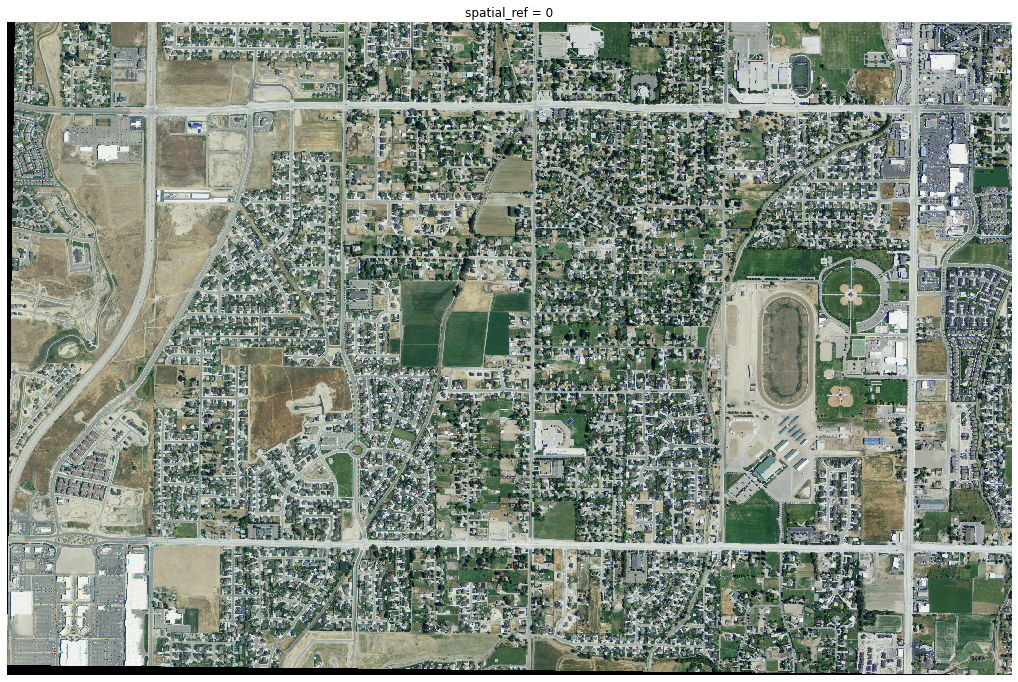

In [8]:
create_image(item_old);

2018-08-28 00:00:00+00:00


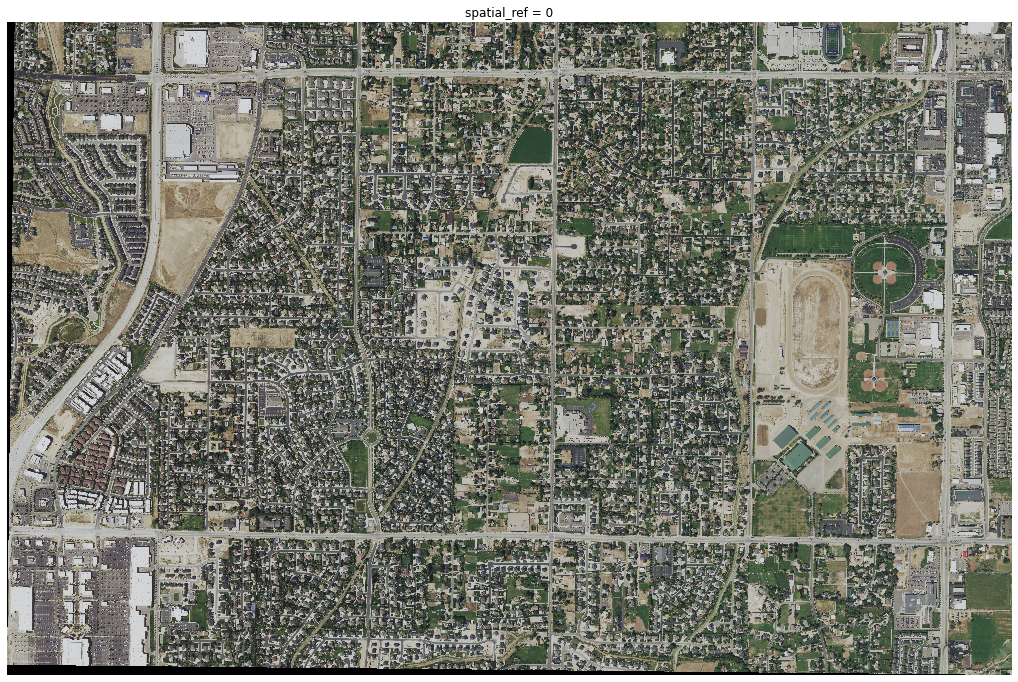

In [9]:
create_image(item_new);